<a href="https://colab.research.google.com/github/jonathabsilva/TecImpIA/blob/main/Avaliacao1TAIA%5BAjustada%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Avaliação 1
Consideração o modelo de previsão de demanda, realizar a análise dos seguintes itens:

1. Modificar as funções de ativação utilizando Relu, Sigmod, tanh, etc. Analisar o desempenho da RNA. ✅

2. Modificar o número de camadas ocultas e neurônios (Sintonização da melhor rede) https://wandb.ai/site 

3. Realizar um estudo sobre o otimizador “Adam”

4. Na fase de teste, avaliar as métricas de:

  a. Erro Relativo Absoluto: |t-s|/t

  b. MAPE ✅

  c. Máximo Erro Relativo Absoluto: max(|t-s|)/t

5. Realizar a Previsão diária considerando um dia para frente e sete dias para atrás, com a finalidade de encontrar a melhor rede com ERA<10% e MAPE<3%. Utilize a 'Normalização' e faça a 'desnormalização' para mostrar os valores da previsão da potência. ✅

# Importação das Bibliotecas

Aqui, importa-se as seguintes bibliotecas:
1. tensorflow - 
2. pandas - 
3. numpy - 
4. matplotlib.pyplot - 



In [27]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
%matplotlib inline

# Leitura e Ajuste dos Dados

In [28]:
from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
df = pd.read_csv('/content/drive/MyDrive/DESENVOLVIMENTO PESSOAL/MESTRADO/TÉCNICAS APLICADAS DE INTELIGÊNCIA ARTIFICIAL/Exemplo Previsão de Demanda/Parte 1 - Atualizado/dados_demanda.csv',delimiter=';')
df.dropna(axis=1,inplace=True)

df['TEMPO'] = df[['DIA','MES','ANO','HORA','MINUTO']].apply(lambda x : datetime(year=x[2],month=x[1],day=x[0],hour=x[3],minute=x[4]), axis=1)
df.drop(['MINUTO','HORA','ANO','DIA','MES'],axis=1,inplace=True)
df.rename(columns={'JPS_12B1':'POTENCIA'},inplace=True)
df['POTENCIA']=df['POTENCIA'].str.replace(',', '.').astype(float)
df.set_index('TEMPO',inplace=True)

In [30]:
maxima_semanal=df.resample('W').agg(['max'])

In [31]:
dias_tras = 7
dias_frente = 1

In [32]:
data = pd.DataFrame()
data['POTÊNCIA'] = maxima_semanal

for i in range(1,dias_tras+1):
  data['POTÊNCIA(K-'+str(i)+')'] = maxima_semanal.shift(i)



for i in range(1,dias_frente+1):
  data['POTÊNCIA(K+'+str(i)+')'] = maxima_semanal.shift(-i)

In [33]:
data.dropna(axis=0, inplace=True)
dataMax = data

In [34]:
np.array(maxima_semanal.agg(['max']))[0][0]

24.1000003814697

In [35]:
fator_treino = 0.72
data_dim, len_data = data.shape #Pega a quantidade de dados. O segundo termo não é necessário, pois já se sabe a quantidade de colunas de treinamento e de saída. 
data_treino_dim = data_dim*fator_treino

len_train = dias_tras+1 #Número de colunas usadas para treino

In [36]:
data = np.array(data)
data = tf.keras.utils.normalize(data,axis=1)

x_train = data[0:216,0:len_train]
y_train = data[0:216,len_train:len_data]

x_test = data[216:308,0:len_train]
y_test = data[216:308,len_train:len_data]

In [37]:
data.shape

(306, 9)

# Treinamento da Rede

In [38]:
funcoes = [tf.nn.relu, tf.nn.sigmoid, tf.nn.tanh, tf.nn.softmax]
medicoes = dict()
val_loss = dict()
val_mse = dict()

for funcao in funcoes:

  # Criando Rede
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Input(8))




  for i in [20,20,1]:
    model.add(tf.keras.layers.Dense(i,activation=funcao))

  # Parâmetros de treinamento
  model.compile(optimizer='adam',
                loss='mean_squared_error',
                metrics = ['mean_squared_error'])

  # Treinando 
  model.fit(x_train,y_train,epochs=500)
  val_loss[funcao], val_mse[funcao] = model.evaluate(x_test,y_test)


Epoch 1/500
7/7 [==============================] - 0s 3ms/step - loss: 0.1128 - mean_squared_error: 0.1128
Epoch 2/500
7/7 [==============================] - 0s 3ms/step - loss: 0.1128 - mean_squared_error: 0.1128
Epoch 3/500
7/7 [==============================] - 0s 3ms/step - loss: 0.1128 - mean_squared_error: 0.1128
Epoch 4/500
7/7 [==============================] - 0s 3ms/step - loss: 0.1128 - mean_squared_error: 0.1128
Epoch 5/500
7/7 [==============================] - 0s 3ms/step - loss: 0.1128 - mean_squared_error: 0.1128
Epoch 6/500
7/7 [==============================] - 0s 3ms/step - loss: 0.1128 - mean_squared_error: 0.1128
Epoch 7/500
7/7 [==============================] - 0s 3ms/step - loss: 0.1128 - mean_squared_error: 0.1128
Epoch 8/500
7/7 [==============================] - 0s 3ms/step - loss: 0.1128 - mean_squared_error: 0.1128
Epoch 9/500
7/7 [==============================] - 0s 3ms/step - loss: 0.1128 - mean_squared_error: 0.1128
Epoch 10/500
7/7 [===================

3/3 [==============================] - 0s 5ms/step - loss: 0.4476 - mean_squared_error: 0.4476


In [39]:
melhor_funcao = list(val_mse.keys()) [list(val_mse.values()).index(min(val_mse.values()))]
melhor_funcao


<function tensorflow.python.ops.gen_math_ops.tanh(x, name=None)>

In [40]:
val_loss

{<function tensorflow.python.ops.gen_nn_ops.relu(features, name=None)>: 0.11010235548019409,
 <function tensorflow.python.ops.math_ops.sigmoid(x, name=None)>: 0.00035902592935599387,
 <function tensorflow.python.ops.gen_math_ops.tanh(x, name=None)>: 0.000345981476129964,
 <function tensorflow.python.ops.nn_ops.softmax_v2(logits, axis=None, name=None)>: 0.4476436972618103}

In [41]:
# Avaliacao numero de camadas e quantidade de neuronios
def camadas_e_neuronios(dados):
  camadas = [
      [20,20,1],
      [10,10,1]
  ]

  return camadas[0]

camadas_e_neuronios(2)

[20, 20, 1]

In [42]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Input(8))
for i in [20,20,1]:
  model.add(tf.keras.layers.Dense(i,activation=melhor_funcao))

# Parâmetros de treinamento
model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics = ['mean_squared_error'])

# Treinando 
model.fit(x_train,y_train,epochs=500)
loss, mse = model.evaluate(x_test,y_test)

Epoch 1/500
7/7 [==============================] - 0s 5ms/step - loss: 0.0805 - mean_squared_error: 0.0805
Epoch 2/500
7/7 [==============================] - 0s 4ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 3/500
7/7 [==============================] - 0s 4ms/step - loss: 0.0062 - mean_squared_error: 0.0062
Epoch 4/500
7/7 [==============================] - 0s 4ms/step - loss: 0.0076 - mean_squared_error: 0.0076
Epoch 5/500
7/7 [==============================] - 0s 4ms/step - loss: 0.0024 - mean_squared_error: 0.0024
Epoch 6/500
7/7 [==============================] - 0s 4ms/step - loss: 0.0011 - mean_squared_error: 0.0011    
Epoch 7/500
7/7 [==============================] - 0s 5ms/step - loss: 0.0016 - mean_squared_error: 0.0016
Epoch 8/500
7/7 [==============================] - 0s 4ms/step - loss: 9.4447e-04 - mean_squared_error: 9.4447e-04
Epoch 9/500
7/7 [==============================] - 0s 4ms/step - loss: 8.7326e-04 - mean_squared_error: 8.7326e-04
Epoch 10/500
7/7 

In [43]:
melhor_funcao

<function tensorflow.python.ops.gen_math_ops.tanh(x, name=None)>

# Examinando o desempenho da rede

In [44]:
maximo = np.array(maxima_semanal.agg(['max']))[0][0]

3/3 [==============================] - 0s 8ms/step - loss: 3.1641e-04 - mean_squared_error: 3.1641e-04


Text(0, 0.5, 'Potência')

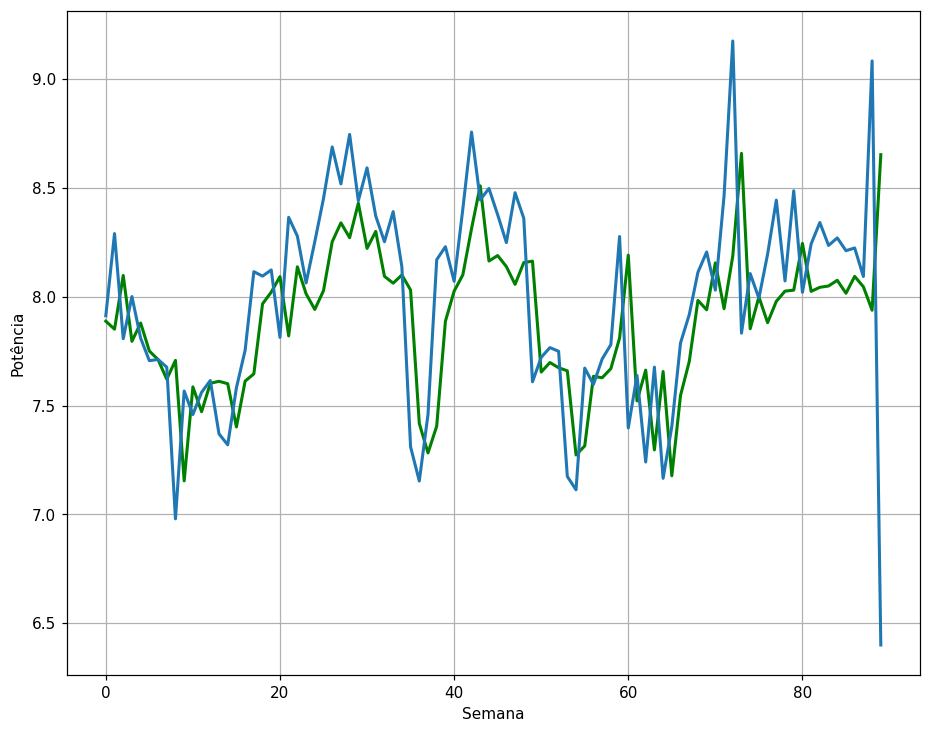

In [45]:
val_loss, val_mse = model.evaluate(x_test,y_test)
y_pred = model.predict(x_test)

plt.figure(figsize=(10,8),dpi=110)
plt.plot(y_pred[:,0]*maximo,lw=2,color='Green')
plt.plot(y_test[:,0]*maximo,lw=2)
plt.grid(True)
#plt.xlim([0,91])
plt.xlabel('Semana')
plt.ylabel('Potência')


In [46]:
val_mse

0.00031641466193832457

#Questão 4
 Na fase de teste, avaliar as métricas de:

  a. Erro Relativo Absoluto: |t-s|/t ✅

  b. MAPE ✅

  c. Máximo Erro Relativo Absoluto: max(|t-s|)/t ✅

In [81]:
def Err_Rel_Abs(a,b):    
  from statistics import mean
  ERA = list()
  for i in range(len(a)):
    ERA.append(abs((a[i] - b[i])/a[i])[0])
  return ERA

In [82]:
Err_Rel_Abs(y_test, y_pred)

[0.003148349926804302,
 0.05302015778887236,
 0.03722959863455028,
 0.02572195848084043,
 0.008883376641014082,
 0.005770821449686999,
 6.194340838473232e-05,
 0.0072153292749183315,
 0.1043830941396414,
 0.05458020809773405,
 0.01703702177568361,
 0.01181127900155422,
 0.0016986351575116528,
 0.03279185601216158,
 0.03837676634352956,
 0.02377105946168256,
 0.018305106518539515,
 0.05789414266476925,
 0.01574529373806491,
 0.012538962555379578,
 0.03575186926000294,
 0.06518992338875747,
 0.01701858227812558,
 0.0061953531212050866,
 0.03776699383582826,
 0.05013106873717244,
 0.05015485743924162,
 0.021003126802924724,
 0.054279411578925525,
 0.0013723786335248578,
 0.04308285385213311,
 0.008428252931481079,
 0.019276298718631606,
 0.03919300525348417,
 0.004546185540333732,
 0.09865758452531521,
 0.03702255611184816,
 0.023688321594551944,
 0.0936448982988944,
 0.041617489084914805,
 0.005663001838360314,
 0.036011125704697645,
 0.05069707826269968,
 0.007580505618445212,
 0.039249

In [84]:
mean(Err_Rel_Abs(y_test, y_pred))

0.03803005136383141

In [47]:
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error

In [48]:
MAPE = mean_absolute_percentage_error(y_test, y_pred)
MAPE 
#val_loss, val_mse = model.evaluate(x_test,y_test)
#y_pred = model.predict(x_test)

0.03803005136383141

In [49]:
MAE = mean_absolute_error(y_test, y_pred)
MAE

0.01240151008291597